In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

## Parameters

In [2]:
TEST_RATIO = 0.0
NUM_DATA = 20
HIDDEN_UNITS = 100
DATA_RANGE = 1 # adjustment on epsilon according to range along a dimension
EPSILON = 0.01
GAUSSIAN_LR = 0.1
NUM_EPOCHS = 50

## Dataset

In [3]:
def func(x):
    return np.power(x, 3) + 100*np.sin(x) + np.random.normal(0, 50, x.shape)

# for training:
data_x = np.random.uniform(-4, 4, size=NUM_DATA)
data_y = np.zeros(NUM_DATA)

# for plotting:
num_data_true = 1000
data_x_true = np.linspace(-6, 6, num_data_true)
data_y_true = np.zeros(num_data_true)

In [4]:
for i in range(NUM_DATA):
    if (data_x[i] < 0): 
        data_y[i] = func(data_x[i]) + np.random.normal(0, 3) # x<0, sigma=3 (less noisy measurement)
    else: 
        data_y[i] = func(data_x[i]) + np.random.normal(0, 9) # x>=0, sigma=9 (more noisy measurement)
        
for i in range(num_data_true):
    data_y_true[i] = func(data_x_true[i])

In [5]:
num_train_data = int(NUM_DATA * (1 - TEST_RATIO))
num_test_data  = NUM_DATA - num_train_data
print("num_train_data: ", num_train_data)

data_x = np.reshape(data_x, [NUM_DATA, 1])
data_y = np.reshape(data_y, [NUM_DATA, 1])
data_y_true = np.reshape(data_y_true, [num_data_true, 1])
data_x_true = np.reshape(data_x_true, [num_data_true, 1])

train_x = data_x[:num_train_data, :]
train_y = data_y[:num_train_data, :]
test_x  = data_x[num_train_data:, :]
test_y  = data_y[num_train_data:, :]

num_train_data:  20


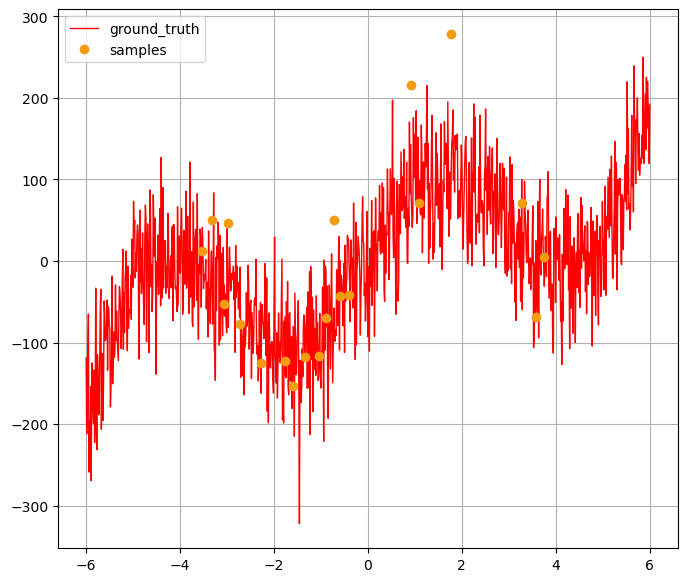

In [6]:
plt.figure(figsize=[8, 7])

plt.plot(data_x_true, data_y_true, 'r', linewidth=1, label='ground_truth')
plt.plot(data_x, data_y, '.', markersize=12, color='#F39C12', label='samples')

plt.legend(loc='best')
plt.grid()
plt.show()

## Define Model

In [7]:
pi = torch.tensor(np.pi)

def gaussian_nll(mean, variance, y):
    return torch.mean((torch.log(variance) * 0.5) + ((0.5 * (y - mean).square()) / variance)) + torch.log(2 * pi)

# 1 hidden layer, ReLU activation 
class MultiLayerPerceptron(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.fc1 = nn.Linear(self.input_dim, HIDDEN_UNITS)
        self.fc2 = nn.Linear(HIDDEN_UNITS, self.output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
# 1 hidden layer, ReLU activation, Gaussian output (mean, variance)
class GaussianMultiLayerPerceptron(MultiLayerPerceptron):
    
    def __init__(self, input_dim, output_dim=2):
        super().__init__(input_dim, output_dim)
 
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        mean, variance = torch.split(x, 1, dim=1)
        variance = F.softplus(variance) + 1e-6 # Positive constraint
        return mean, variance

In [8]:
tensor_x = torch.Tensor(train_x) # transform to torch tensor
tensor_y = torch.Tensor(train_y)

toy_dataset = TensorDataset(tensor_x, tensor_y) # create your datset
dataloader = DataLoader(toy_dataset, num_workers=1, batch_size=1, shuffle=True) # create your dataloader

In [9]:
# FGSM attack code / adversarial attack input generation
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    return perturbed_image

## Training

In [10]:
# train the model:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
model = GaussianMultiLayerPerceptron(1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=GAUSSIAN_LR)

# tqdm print the loss
for epoch in tqdm(range(NUM_EPOCHS), desc='Training Gaussian MLP', unit='epoch'):

    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        data.requires_grad = True
        output = model(data)
        loss = gaussian_nll(output[0], output[1], target)
        loss.backward()

        # Adversarial attack:
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, EPSILON, data_grad)
        perturbed_output = model(perturbed_data)
        adversarial_loss = gaussian_nll(perturbed_output[0], perturbed_output[1], target)
        adversarial_loss.backward()
        optimizer.step()


Training Gaussian MLP: 100%|██████████| 50/50 [00:07<00:00,  6.79epoch/s]


In [11]:
model.eval()
means = []
variances = []

for x in data_x_true:
    mean, var = model(torch.Tensor(x).unsqueeze(0).to(device))
    means.append(mean.item())
    variances.append(var.item())

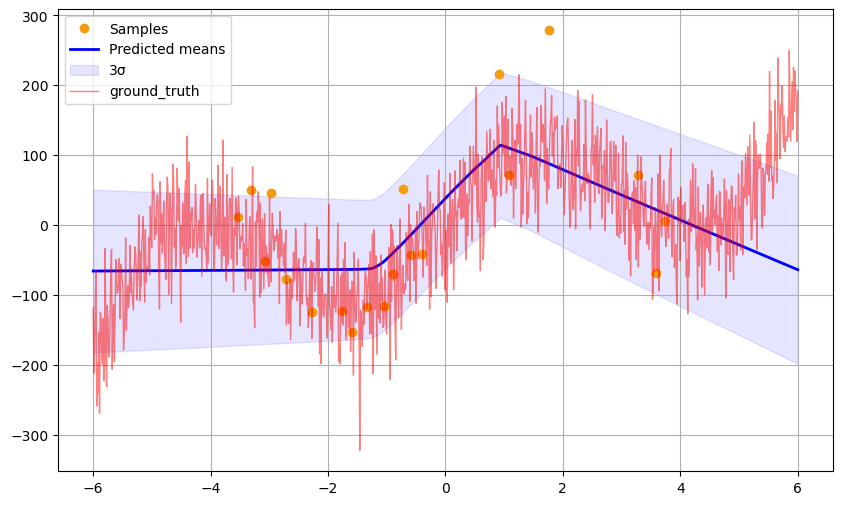

In [12]:
upper = [i + np.sqrt(k) * 3 for i, k in zip(means, variances)]
lower = [i - np.sqrt(k) * 3 for i, k in zip(means, variances)]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# plt.axvline(x=0, linewidth=2)
plt.plot(data_x, data_y, 'o', markersize=6, color='#F39C12')
plt.plot(data_x_true, means, linewidth=2, color='b')
plt.fill_between(data_x_true.flatten(), upper, lower, color="blue", alpha=0.1)
plt.plot(data_x_true, data_y_true, 'r', linewidth=1, alpha=0.5)
plt.legend(['Samples', 'Predicted means' , '3σ', 'ground_truth'], loc = 'best')
plt.grid()
plt.show() 